# Table of content
## 1. Load data
## 2. Visualize and explore data
## 3. Preprocess data
## 4. Feature selection, extraction and engineering
## 5. Proposed model, trainning, parameters tunning and evaluation

## 1. Load data

### Import các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

### Đọc dữ liệu từ các file csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

train=pd.read_csv('/content/train.csv')
features=pd.read_csv('/content/features.csv')
stores = pd.read_csv('/content/stores.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [ ]:
features.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## 2. Visualize and explore data

Ở phần này sẽ visualize sự ảnh hưởng của các thuộc tính dạng categorical tới Weekly_Sales. Còn các thuộc tính dạng numerical sẽ visualize ở phần Preprocess Data sau khi data đã được tiền xử lý

### Tỉ lệ các loại store

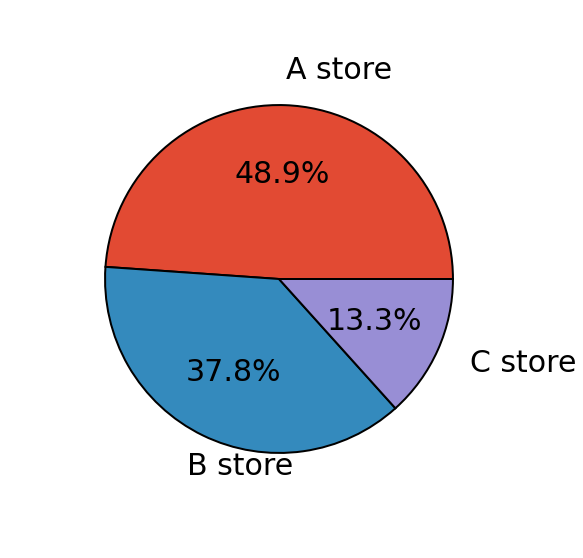

In [ ]:

sorted_type = stores.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
wprops={'edgecolor':'black',
      'linewidth':2}
tprops = {'fontsize':30}
axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

In [ ]:
train_stores = train.merge(stores, on = ['Store'], how = 'inner')
train_stores.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


### So sánh lượng sale trung bình giữa holiday và non-holiday

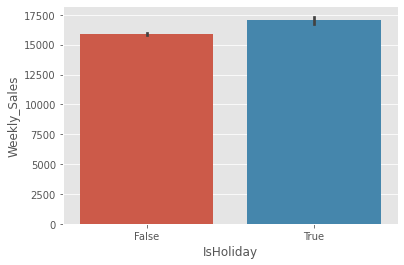

In [ ]:

holiday = train_stores['Weekly_Sales'].loc[train_stores['IsHoliday']== True] # Weekly Sales in Holidays
non_holiday = train_stores['Weekly_Sales'].loc[train_stores['IsHoliday']== False] #Weekly Sales in Non-holidays.
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=train_stores)
sns.set_style('darkgrid')
sns.set_palette('Set2')

### So sánh lượng sale trung bình giữa các loại store

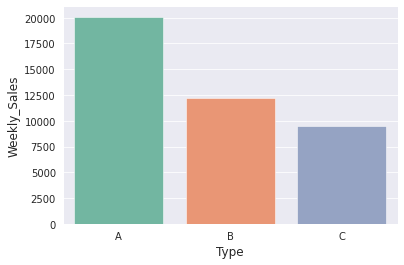

In [ ]:

sns.barplot(x = 'Type', y = 'Weekly_Sales', data = train_stores, ci = None)
sns.set_style('darkgrid')
sns.set_palette('Set2')


### Sales theo loại store và Holiday

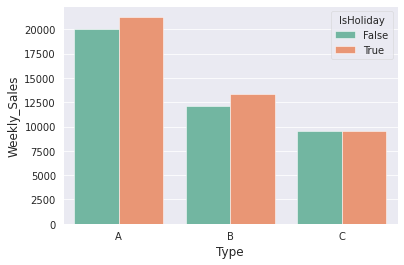

In [ ]:
# sale theo store va Is_Holiday
sns.barplot(x = 'Type', y = 'Weekly_Sales', hue = 'IsHoliday', data = train_stores, ci = None)
sns.set_style('darkgrid')
sns.set_palette('Set2')

### Sale theo department

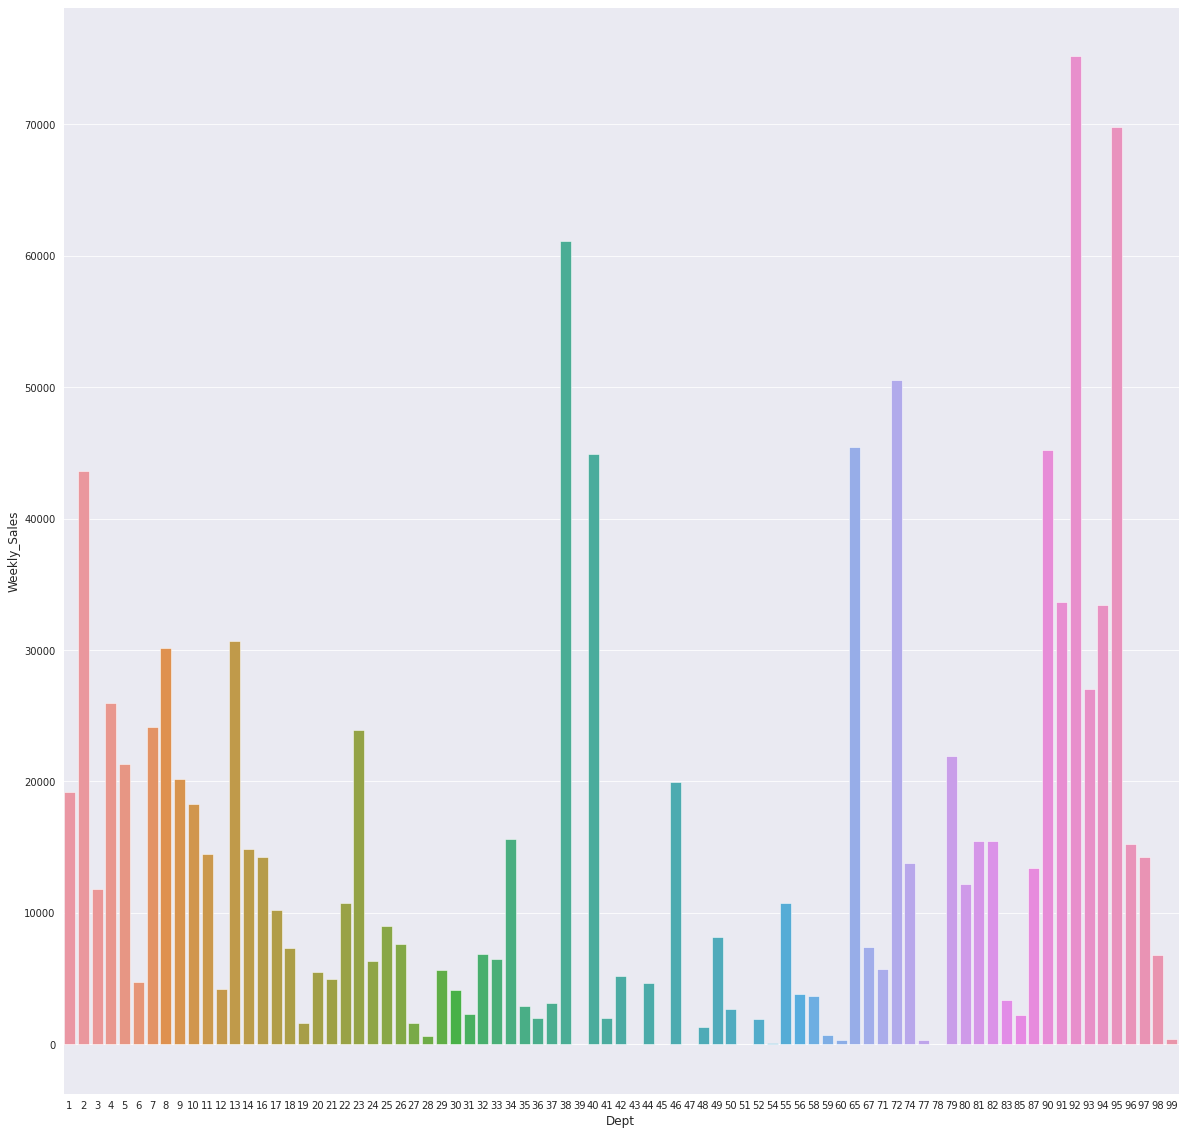

In [ ]:
plt.figure(figsize = (20,20))
sns.barplot(x = 'Dept', y = 'Weekly_Sales', data = train_stores, ci = None)
sns.set_style('darkgrid')
sns.set_palette('Set2')

### Sale theo store

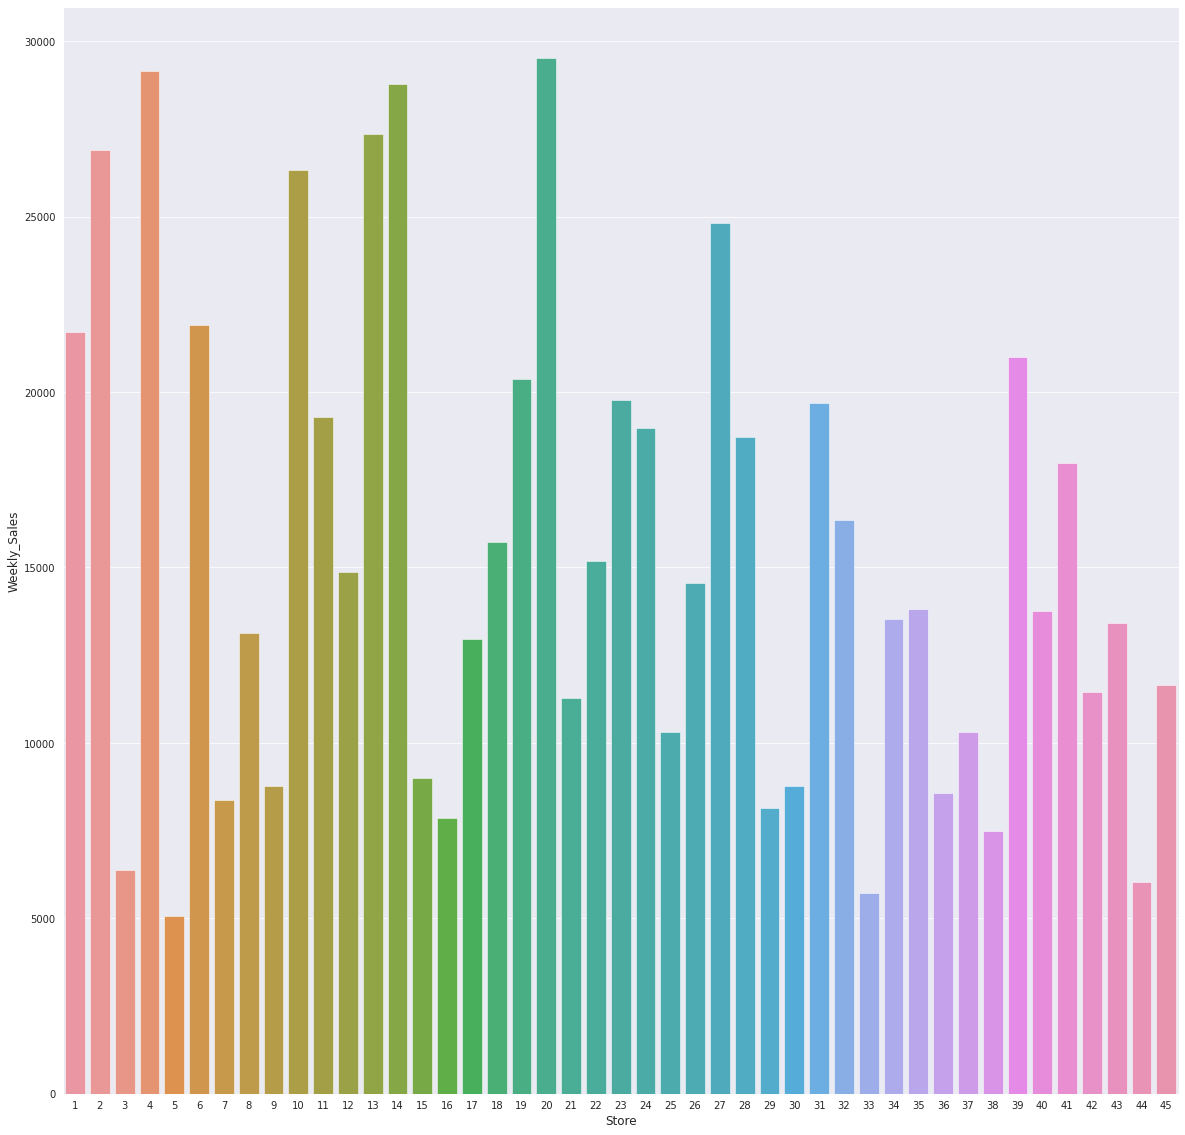

In [ ]:
# sale theo store
plt.figure(figsize = (20,20))
sns.barplot(x = 'Store', y = 'Weekly_Sales', data = train_stores, ci = None)
sns.set_style('darkgrid')
sns.set_palette('Set2')

## 3. Preprocess data

### Kết nối các bảng

In [ ]:
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


### Drop các giá trị null và âm

In [ ]:
data = data.fillna(0)
data = data[data['Weekly_Sales'] >= 0]

### Drop cột thừa


In [ ]:
data.drop('IsHoliday_y', axis = 1, inplace = True)
data['IsHoliday'] = data['IsHoliday_x']
data.drop('IsHoliday_x', axis = 1, inplace = True)
data

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
1,1,2,2010-02-05,50605.27,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
2,1,3,2010-02-05,13740.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
3,1,4,2010-02-05,39954.04,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
4,1,5,2010-02-05,32229.38,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False
421566,45,94,2012-10-26,5203.31,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False
421567,45,95,2012-10-26,56017.47,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False
421568,45,97,2012-10-26,6817.48,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False


### Chuyển các categorical feature thành numerical

In [ ]:
train_data = [data]
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)


In [ ]:
type_mapping = {False: 0, True: 1}
for dataset in train_data:
     dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)
data

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0
1,1,2,2010-02-05,50605.27,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0
2,1,3,2010-02-05,13740.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0
3,1,4,2010-02-05,39954.04,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0
4,1,5,2010-02-05,32229.38,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0
421566,45,94,2012-10-26,5203.31,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0
421567,45,95,2012-10-26,56017.47,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0
421568,45,97,2012-10-26,6817.48,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0


### Tạo các feature mới

In [ ]:
data['Super_Bowl'] = np.where(
(data['Date']==datetime(2010,2,10).strftime("%Y-%m-%d"))|
(data['Date'] == datetime(2011,2,11).strftime("%Y-%m-%d"))| 
(data['Date'] == datetime(2012,2,10).strftime("%Y-%m-%d"))|
(data['Date'] == datetime(2013,2,8).strftime("%Y-%m-%d")), 1, 0)
data['Labor_day'] = np.where(
(data['Date'] == datetime(2010,9,10).strftime("%Y-%m-%d"))|
(data['Date'] == datetime(2011,9,9).strftime("%Y-%m-%d"))| 
(data['Date'] == datetime(2012,9,7).strftime("%Y-%m-%d"))|
(data['Date'] == datetime(2013,9,6).strftime("%Y-%m-%d")), 1, 0)
data['Thanksgiving'] = np.where(
(data['Date']==datetime(2010, 11, 26).strftime("%Y-%m-%d")) | 
(data['Date']==datetime(2011, 11, 25).strftime("%Y-%m-%d")) | 
(data['Date']==datetime(2012, 11, 23).strftime("%Y-%m-%d")) |
(data['Date']==datetime(2013, 11, 29).strftime("%Y-%m-%d")),1,0)
data['Christmas'] = np.where(
(data['Date']==datetime(2010, 12, 31).strftime("%Y-%m-%d"))|
(data['Date']==datetime(2011, 12, 30).strftime("%Y-%m-%d"))| 
(data['Date']==datetime(2012, 12, 28).strftime("%Y-%m-%d"))|
(data['Date']==datetime(2013, 12, 27).strftime("%Y-%m-%d")),1,0)

### Drop date và phân tập train, test, validate

In [ ]:
data = data.sort_values(by='Date', ascending=True)
data.drop('Date', axis = 1, inplace = True)
y = data['Weekly_Sales']
X = data.drop(['Weekly_Sales'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25)

### Heatmap

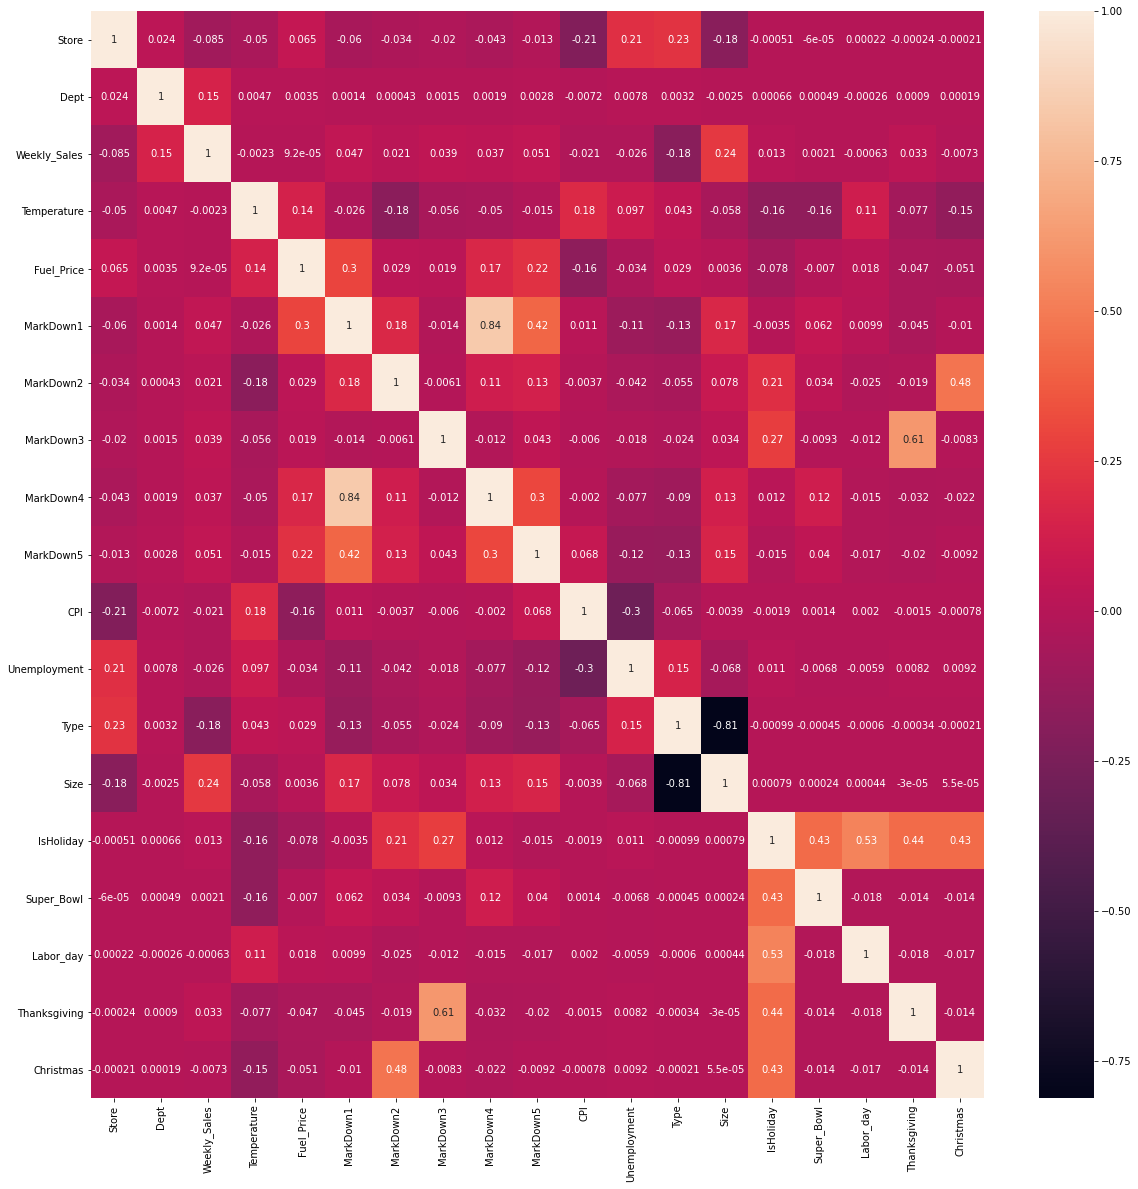

In [ ]:
plt.figure(figsize = (20,20))
# feats = ['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown3', 'CPI', 'Unemployment', 'Type', 'Size', 'IsHoliday']
corrMt = data.corr()
sns.heatmap(corrMt, annot = True)
plt.show()

# MODEL 1: Linear Regression, Deep Learning

In [ ]:
def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

In [ ]:
# chuẩn hoá giá trị về khoảng 0-1 sử dụng min max scaler

from sklearn.preprocessing import MinMaxScaler
train_columns = X_train.columns
mat_x_train = np.matrix(X_train)
mat_y_train = np.matrix(y_train).reshape((252171 , 1))
mat_x_test = np.matrix(X_test)
mat_y_test = np.matrix(y_test).reshape((84057 , 1))
prepo_x_train=MinMaxScaler()
prepo_x_train.fit(mat_x_train)
prepo_x_test=MinMaxScaler()
prepo_x_test.fit(mat_x_test)
prepo_y_train=MinMaxScaler()
prepo_y_train.fit(mat_y_train)
prepo_y_test=MinMaxScaler()
prepo_y_test.fit(mat_y_test)
train = pd.DataFrame(prepo_x_train.transform(mat_x_train), columns= train_columns)
train.head()

,Store,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday,Super_Bowl,Labor_day,Thanksgiving,Christmas
0,0.250000,0.938776,0.765753,0.324649,0.000000,0.002536,0.000205,0.000000,0.000000,0.001190,0.979490,0.5,0.418751,0.0,0.0,0.0,0.0,0.0
1,0.068182,0.438776,0.356849,0.396293,0.041358,0.141424,0.000745,0.012158,0.054878,0.041317,0.069772,0.0,0.925525,0.0,0.0,0.0,0.0,0.0
2,0.727273,0.806122,0.639922,0.623246,0.000000,0.002536,0.000205,0.000000,0.000000,0.025226,0.486103,0.0,0.026063,0.0,0.0,0.0,0.0,0.0
3,0.204545,0.959184,0.524168,0.455411,0.000000,0.002536,0.000205,0.000000,0.000000,0.017744,0.466264,0.5,0.496013,1.0,1.0,0.0,0.0,0.0
4,0.340909,0.214286,0.161448,0.430361,0.025151,0.002803,0.000726,0.025146,0.059581,0.690037,0.225513,0.5,0.120825,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train = prepo_x_train.transform(mat_x_train)
X_test = prepo_x_test.transform(mat_x_test)
y_train = prepo_y_train.transform(mat_y_train)
y_test = prepo_y_test.transform(mat_y_test)

MODEL 1: Linear Regression, loss : mse, acc: r2_score

In [ ]:
from sklearn import linear_model
import sklearn
from sklearn.metrics import mean_squared_error, r2_score

cfl = linear_model.LinearRegression()

cfl.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(wmae_test(y_test, diabetes_y_pred))

14896.535731985949


In [ ]:
diabetes_y_pred = cfl.predict(X_test)

print('Coefficients: \n', cfl.coef_)

print('Mean squared error: %.2f'
      % (mean_squared_error(y_test, diabetes_y_pred)*100))
A1=mean_squared_error(y_test, diabetes_y_pred)
print('Coefficient of determination: %.2f'
      % r2_score(y_test, diabetes_y_pred))

Coefficients: 
 [-9.44389527e+01  1.12974702e+02  2.71285263e+01 -5.41035822e+02
 -1.29262617e-03  1.97448236e-02  3.74617196e-02  1.86541723e-02
  9.13420032e-02 -2.30696807e+01 -2.26803960e+02  1.99317381e+03
  1.04181284e-01  7.42239723e+02  8.00015845e+01 -1.17157873e+03
  5.00162907e+03 -2.03826940e+03]
Mean squared error: 47894349790.71
Coefficient of determination: 0.09


In [ ]:
print(diabetes_y_pred)

[[ 0.02159877]
 [ 0.04474242]
 [ 0.02749842]
 ...
 [ 0.022497  ]
 [-0.00060373]
 [ 0.02287617]]


Nhận xét: Bài toán thuộc loại bài toán phân cụm dựa trên các features, nên có vẻ việc sử dụng linear regression như các bài dự đoán giá sẽ không hiệu quả với độ chính xác rất thấp (r2_score ~ 9%)

Model 2. Deep Learning dựa trên Linear Regression

In [ ]:
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import io
import numpy as np

In [ ]:
# model
model = Sequential()
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# train
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
          batch_size=128, epochs=5,callbacks=[early_stop])
model.summary()

Epoch 1/5
1971/1971 [==============================] - 6s 3ms/step - loss: 6.0920e-04 - val_loss: 7.4183e-04
Epoch 2/5
1971/1971 [==============================] - 6s 3ms/step - loss: 6.1271e-04 - val_loss: 7.1303e-04
Epoch 3/5
1971/1971 [==============================] - 5s 3ms/step - loss: 5.6860e-04 - val_loss: 6.6742e-04
Epoch 4/5
1971/1971 [==============================] - 6s 3ms/step - loss: 5.3882e-04 - val_loss: 7.4091e-04
Epoch 5/5
1971/1971 [==============================] - 5s 3ms/step - loss: 5.1621e-04 - val_loss: 6.2824e-04
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_8 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_9 (Dense)              (None, 1

In [ ]:
pred_3=model.predict(X_test)
print(sklearn.metrics.r2_score(y_test, pred_3, sample_weight=None, multioutput='uniform_average'))

0.5164866784356064


Kết quả có khá hơn ( r2 = 0.59) tuy nhiên kết quả này vẫn không đạt kỳ vọng. 

Model 3: Ensemble Learning


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

fitted4 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [ ]:
pred_4 = fitted4.predict(X_test)
print(sklearn.metrics.r2_score(y_test, pred_4, sample_weight=None, multioutput='uniform_average'))

0.9393963808934197


Với Ensemble learning, ta đã có độ chính xác khá cao : ~94%.

# MODEL 2: Random Forest, KNN

## 6. Model 2 - Random Forest, KNN


### Evaluate metric

In [ ]:
def wmae_train(test, pred): 
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if   is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error
def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error
def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

In [ ]:
# Importing the most popular regression libraries.
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
# from xgboost import XGBRegressor

### Random Forest

In [ ]:
error_cv_rf = []
error_train_rf = []
max_depth = [5, 15, 20, 30, 50]
n_estimators = [20, 50, 80, 100]
rf_hyperparams = []

for i in max_depth: 
    for j in n_estimators: 
        rf = RandomForestRegressor(max_depth=i, n_estimators=j) 
        rf.fit(X_train, y_train) 
        y_pred_cv_rf = rf.predict(X_cv) 
        y_pred_train_rf = rf.predict(X_train)
        cv_err = wmae_cv(y_cv, y_pred_cv_rf)
        error_cv_rf.append(cv_err) 
        error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) 
        rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j})
        print(cv_err)

9468.859008978068
9501.889917538087
9515.025048822274
9468.523597940371
2516.2879266094333
2507.4810522668868
2501.4300410418746
2495.113626775413
2159.6888606554617
2132.912008173459
2132.4613702035167
2129.2796995933363
2116.3950677997504
2079.1089197140363
2073.3973904512895
2067.528763097192
2110.225782740103
2073.750463920956
2074.606257158504
2068.1351497777123


In [ ]:
rf_dataframe = pd.DataFrame(rf_hyperparams)
rf_dataframe['Train Error']=error_train_rf
rf_dataframe['CV Error']=error_cv_rf
rf_dataframe.sort_values(by=['CV Error'], ascending=True)


,Maximum Depth,No. of Estimators,Train Error,CV Error
15,30,100,769.082684,2067.528763
19,50,100,764.796620,2068.135150
14,30,80,773.314656,2073.397390
17,50,50,775.507281,2073.750464
18,50,80,767.461193,2074.606257
13,30,50,782.615648,2079.108920
16,50,20,804.207241,2110.225783
12,30,20,807.290083,2116.395068
11,20,100,1135.528803,2129.279700
10,20,80,1136.559324,2132.461370


In [ ]:
X_after_train = pd.concat([X_train, X_cv], axis=0)
y_after_train = pd.concat([y_train, y_cv], axis=0)

In [ ]:
best_rf_model = RandomForestRegressor(max_depth = 30, n_estimators=100).fit(X_after_train, y_after_train)

In [ ]:
y_pred_rf = best_rf_model.predict(X_test) # Predict the test data.

In [ ]:
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred_rf)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 1993.2618745944874


### KNN

In [ ]:
error_cv_knn = []
error_train_knn = []
n_neighbors = list(range(1,10))

for k in n_neighbors: 
    knn = KNeighborsRegressor(n_neighbors = k, n_jobs = -1) 
    knn.fit(X_train, y_train) 
    y_pred_cv_knn = knn.predict(X_cv) 
    y_pred_train_knn = knn.predict(X_train)
    cv_err = wmae_cv(y_cv, y_pred_cv_knn)
    error_cv_knn.append(cv_err) 
    error_train_knn.append(wmae_train(y_train, y_pred_train_knn)) 
    print(cv_err)

11693.627495956298
10600.992225375023
10346.252760468176
10388.409354717958
10468.085584187516
10569.798391608823
10644.810628928988
10724.772967648092
10809.690227997908


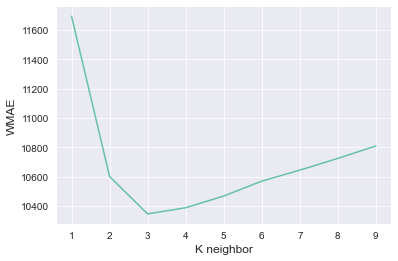

In [ ]:
# plot knn result
plt.xlabel('K neighbor')
plt.ylabel('WMAE')
plt.plot(n_neighbors, error_cv_knn)